# Importing and loading the required data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from jmodt.utils.calibration import Calibration
from jmodt.utils.kitti_utils import get_objects_from_label, boxes3d_to_corners3d
from jmodt.utils.object3d import Object3d

In [2]:
# Define paths to required files
calib_file = "/home/umusa/JMODT/data/tracking/training/calib/0001.txt"
image_file = "/home/umusa/JMODT/data/tracking/training/image_02/0001/000001.png"
lidar_file = "/home/umusa/JMODT/data/tracking/training/velodyne/0001/000001.bin"
label_file = "/home/umusa/JMODT/data/tracking/training/label_02/0001.txt"

In [3]:
# Check if files exist
assert os.path.exists(calib_file), f"Calibration file not found: {calib_file}"
assert os.path.exists(image_file), f"Image file not found: {image_file}"
assert os.path.exists(lidar_file), f"LiDAR file not found: {lidar_file}"
assert os.path.exists(label_file), f"Label file not found: {label_file}"

# Loading the calibration parameters

In [4]:
# Load calibration parameters
calib = Calibration(calib_file)

In [5]:
# Display calibration parameters
print("P2 Matrix:\n", calib.P2)
print("R0 Matrix:\n", calib.R0)
print("Tr_velo2cam Matrix:\n", calib.V2C)

P2 Matrix:
 [[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
R0 Matrix:
 [[ 0.9999239   0.00983776 -0.00744505]
 [-0.0098698   0.9999421  -0.00427846]
 [ 0.00740253  0.00435161  0.9999631 ]]
Tr_velo2cam Matrix:
 [[ 7.533745e-03 -9.999714e-01 -6.166020e-04 -4.069766e-03]
 [ 1.480249e-02  7.280733e-04 -9.998902e-01 -7.631618e-02]
 [ 9.998621e-01  7.523790e-03  1.480755e-02 -2.717806e-01]]


# Loading and visualizing image

In [6]:
# Load the image
img = cv2.imread(image_file)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

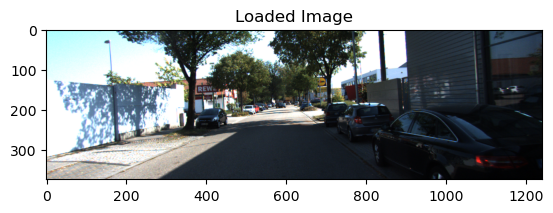

In [7]:
# Visualize the image
plt.imshow(img_rgb)
plt.title("Loaded Image")
plt.show()

# Loading and projecting LiDar points

In [8]:
# Load LiDAR points
lidar_points = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)
pts_lidar = lidar_points[:, :3]  # Extract only (x, y, z)

In [9]:
# Project LiDAR points onto the image
pts_img, pts_depth = calib.lidar_to_img(pts_lidar)

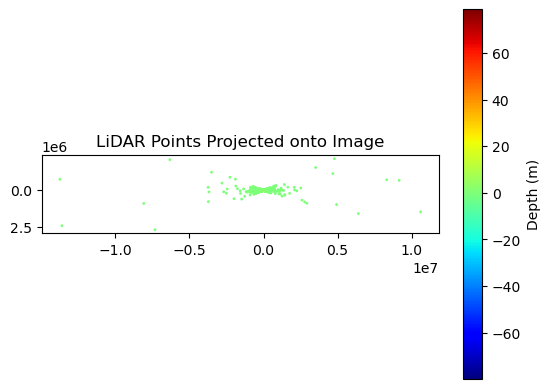

In [10]:
# Visualize the projection
plt.imshow(img_rgb)
plt.scatter(pts_img[:, 0], pts_img[:, 1], c=pts_depth, s=1, cmap='jet')
plt.colorbar(label="Depth (m)")
plt.title("LiDAR Points Projected onto Image")
plt.show()

# Loading and Visualizing 3D Bounding boxes

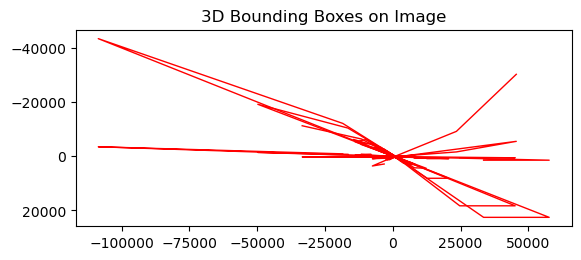

In [11]:
# Load object labels
objects = get_objects_from_label(label_file)

# Convert objects to 3D bounding box corners
boxes3d = np.array([[obj.pos[0], obj.pos[1], obj.pos[2], obj.h, obj.w, obj.l, obj.ry] 
                    for obj in objects if obj.cls_type != "DontCare"])
corners3d = boxes3d_to_corners3d(boxes3d)

# Project 3D bounding boxes onto the image
boxes, boxes_corner = calib.corners3d_to_img_boxes(corners3d)

# Visualize the 3D bounding boxes
plt.imshow(img_rgb)
for i in range(len(boxes_corner)):
    plt.plot(boxes_corner[i, :, 0], boxes_corner[i, :, 1], 'r-', lw=1)
plt.title("3D Bounding Boxes on Image")
plt.show()

# Testing Utility Functions

### Transforming LiDar to Camera Coordinates

In [12]:
# Test LiDAR to Rectified Camera Coordinates
pts_rect = calib.lidar_to_rect(pts_lidar)
print("First 5 Points in Rectified Camera Coordinates:\n", pts_rect[:5])


First 5 Points in Rectified Camera Coordinates:
 [[-6.5866504 -1.9242351 72.49671  ]
 [-6.668606  -1.9151947 72.1306   ]
 [-5.4417877 -1.570339  56.895885 ]
 [-5.507646  -1.5428404 55.728554 ]
 [-5.5094395 -1.5028821 54.000042 ]]


### Transforming Camera to Image Coordinates

In [13]:
# Test Rectified Camera to Image Coordinates
pts_img, pts_depth = calib.rect_to_img(pts_rect)
print("First 5 Points in Image Coordinates:\n", pts_img[:5])


First 5 Points in Image Coordinates:
 [[544.62317 153.70566]
 [543.47375 153.69891]
 [541.3365  152.94322]
 [539.05475 152.88219]
 [536.774   152.77681]]


### Convert Depth Map to Rectified Coordinates

In [14]:
# Test Depth Map to Rectified Coordinates
depth_map = np.random.rand(img.shape[0], img.shape[1]) * 100  # Simulated depth map
pts_rect_from_depth, x_idxs, y_idxs = calib.depthmap_to_rect(depth_map)
print("First 5 Points from Depth Map:\n", pts_rect_from_depth[:5])


First 5 Points from Depth Map:
 [[ -6.26811319  -1.76013237   7.34600001]
 [-52.12066376 -14.78689319  61.72309911]
 [-29.74541031  -8.44534696  35.25183027]
 [-11.7840818   -3.34074735  13.94389941]
 [-68.73639604 -19.60302846  81.82690455]]


# End-to-End Test

In [15]:
# End-to-End Calibration Test
lidar_points = np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)
pts_lidar = lidar_points[:, :3]  # Extract (x, y, z)
pts_img, pts_depth = calib.lidar_to_img(pts_lidar)

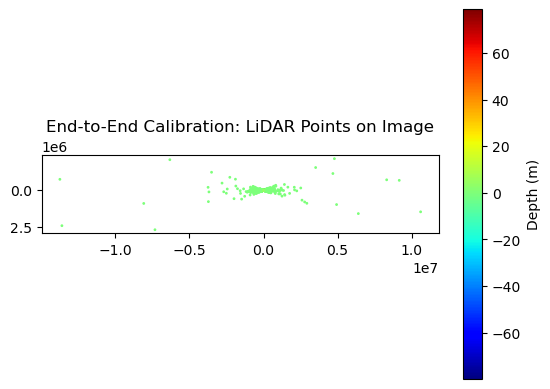

In [16]:
# Visualize end-to-end results
plt.imshow(img_rgb)
plt.scatter(pts_img[:, 0], pts_img[:, 1], c=pts_depth, s=1, cmap='jet')
plt.colorbar(label="Depth (m)")
plt.title("End-to-End Calibration: LiDAR Points on Image")
plt.show()